## Градиентный бустинг

Идея бустинга: будем обучать алгоритмы в композиции не независимо, а последовательно, так, чтобы каждый следующий старался исправить ошибки построенной композиции. Начальное предсказание можно просто инициализировать константой. Далее, пусть $N - 1$ алгоритмов в композиции уже построены:

$$
a_{N - 1}(x) = \sum\limits_{n = 1}^{N - 1}b_n(x)
$$

Следующий алгоритм $b_N(x)$ получается из следующей задачи оптимизации:

$$
\frac{1}{\ell}\sum\limits_{i=1}^{\ell}\left(b_N(x_i) - (y_i - a_{N - 1}(x_i))\right)^2 \to \min\limits_{b_N}
$$

Таким образом, если удастся решить эту задачу идеально, то для каждого объекта $x_i$ будет верно:

$$
b_N(x_i) - (y_i - a_{N - 1}(x_i)) = 0 \Rightarrow y_i = a_{N - 1}(x_i) + b_N(x_i) = a_N(x_i)
$$

**Общий вид.** Пусть $L$ — функция потерь. Тогда общая задача оптимизации выглядит следующим образом:

$$
\frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a(x_i)\right) \to \min_a,
$$

где $a$ — это взвешенная комбинация базовых моделей:

$$
a(x_i) = \sum\limits_n\gamma_nb_n(x_i)
$$

Далее, пусть $N - 1$ алгоритмов в композиции уже построены:

$$
a_{N - 1}(x) = \sum\limits_{n = 1}^{N - 1}\gamma_nb_n(x)
$$

Следующий алгоритм $b_N(x)$ получается из следующей задачи оптимизации:

$$
\frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma_Nb_N(x_i)\right) \to \min\limits_{\gamma_N,\  b_N}
$$

Таким образом, для каждого $x_i$ мы хотим найти $b_N(x_i)$, минимизирующий $L\left(y_i, a_{N - 1}(x_i) + b_N(x_i)\right)$, а также оптимальную длину шага. Для этого давайте проделаем что-то вроде градиентного спуска в пространстве алгоритмов:

$$
b_N(x_i) = -\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}
$$

**Упражнение.** Какую задачу решает базовый алгоритм $b_n(x)$?

**Ответ.** Задачу регрессии (даже если если композиция строится для решения задачи классификации).

Если подставить полученное значение $b_N(x_i)$ в задачу оптимизации, то можно заметить, что мы действительно "сдвинули" значение функции потерь в сторону антиградиента (наискорейшего убывания по $z$). Следовательно, градиентный бустинг можно рассматривать как процесс градиентного спуска в пространстве алгоритмов.


$$
\frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) 
- 
\gamma_N 
\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)} \right) \to \min\limits_{\gamma_N}
$$

Итак, очередной базовый алгоритм $b_N(x)$ можно обучить предсказывать $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x)}$ (антиградиент функции потерь по второму аргументу в точке $a_{N - 1}(x)$).

В свою очередь, после этого уже можно получить оптимальный шаг:

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

В случае бэггинга все базовые алгоритмы настраиваются на различные выборки из одного и того же распределения на $\mathbb{X} \times \mathbb{Y}$. При этом некоторые из них могут оказаться переобученными, однако усреднение позволяет ослабить этот эффект (объясняется тем, что для некоррелированных алгоритмов разброс композиции оказывается в $N$ раз меньше разброса отдельных алгоритмов, т.е. много деревьев с меньшей вероятностью настроятся на некоторый нетипичный объект по сравнению с одним деревом). Если $N$ достаточно велико, то последующие добавления новых алгоритмов уже не позволят улучшить качество модели.

В случае же бустинга каждый алгоритм настраивается на ошибки всех предыдущих, это позволяет на каждом шаге настраиваться на исходное распределение все точнее и точнее. Однако при достаточно большом $N$ это является источником переобучения, поскольку последующие добавления новых алгоритмов будут продолжать настраиваться на обучающую выборку, уменьшая ошибку на ней, при этом уменьшая обобщающую способность итоговой композиции.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import numpy as np
import matplotlib.pyplot as plt

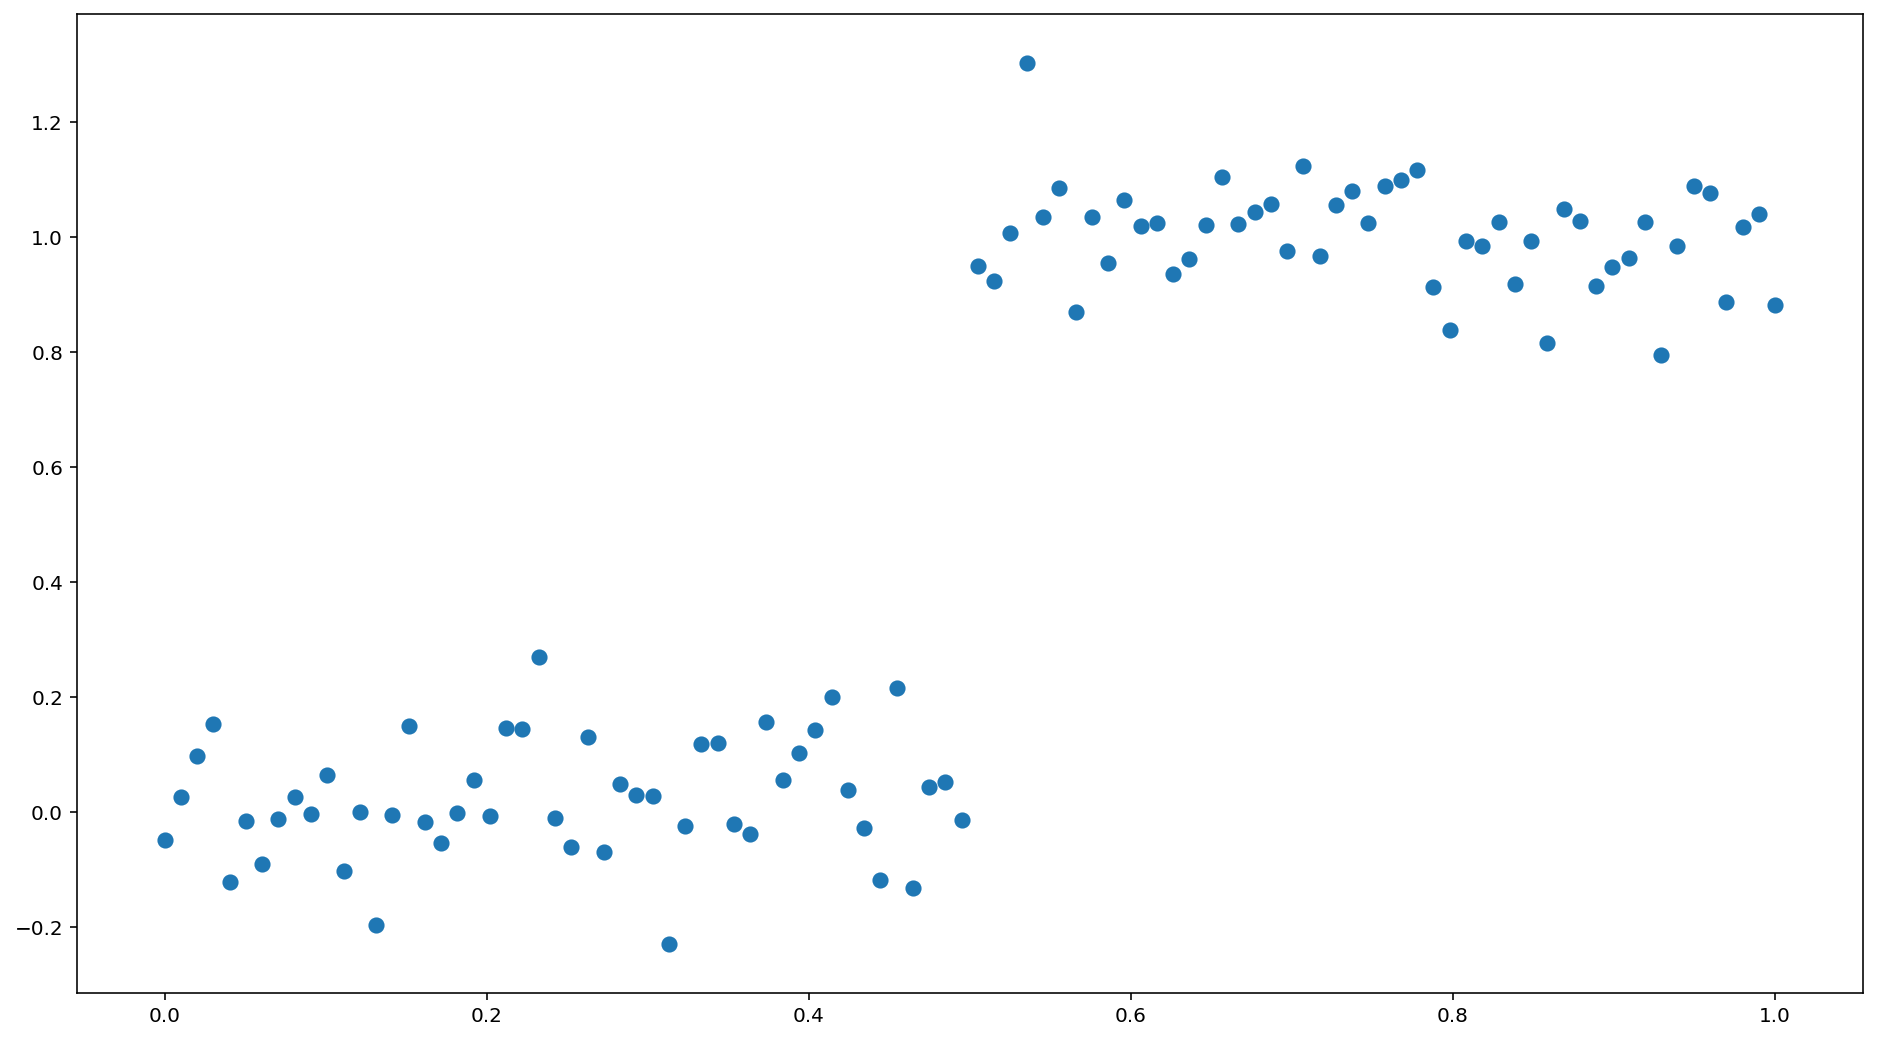

In [2]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

Y_train = (X_train > 0.5).astype(int) + np.random.randn(len(X_train)) * 0.1

plt.figure(figsize = (16, 9))
plt.scatter(X_train, Y_train, s=50)

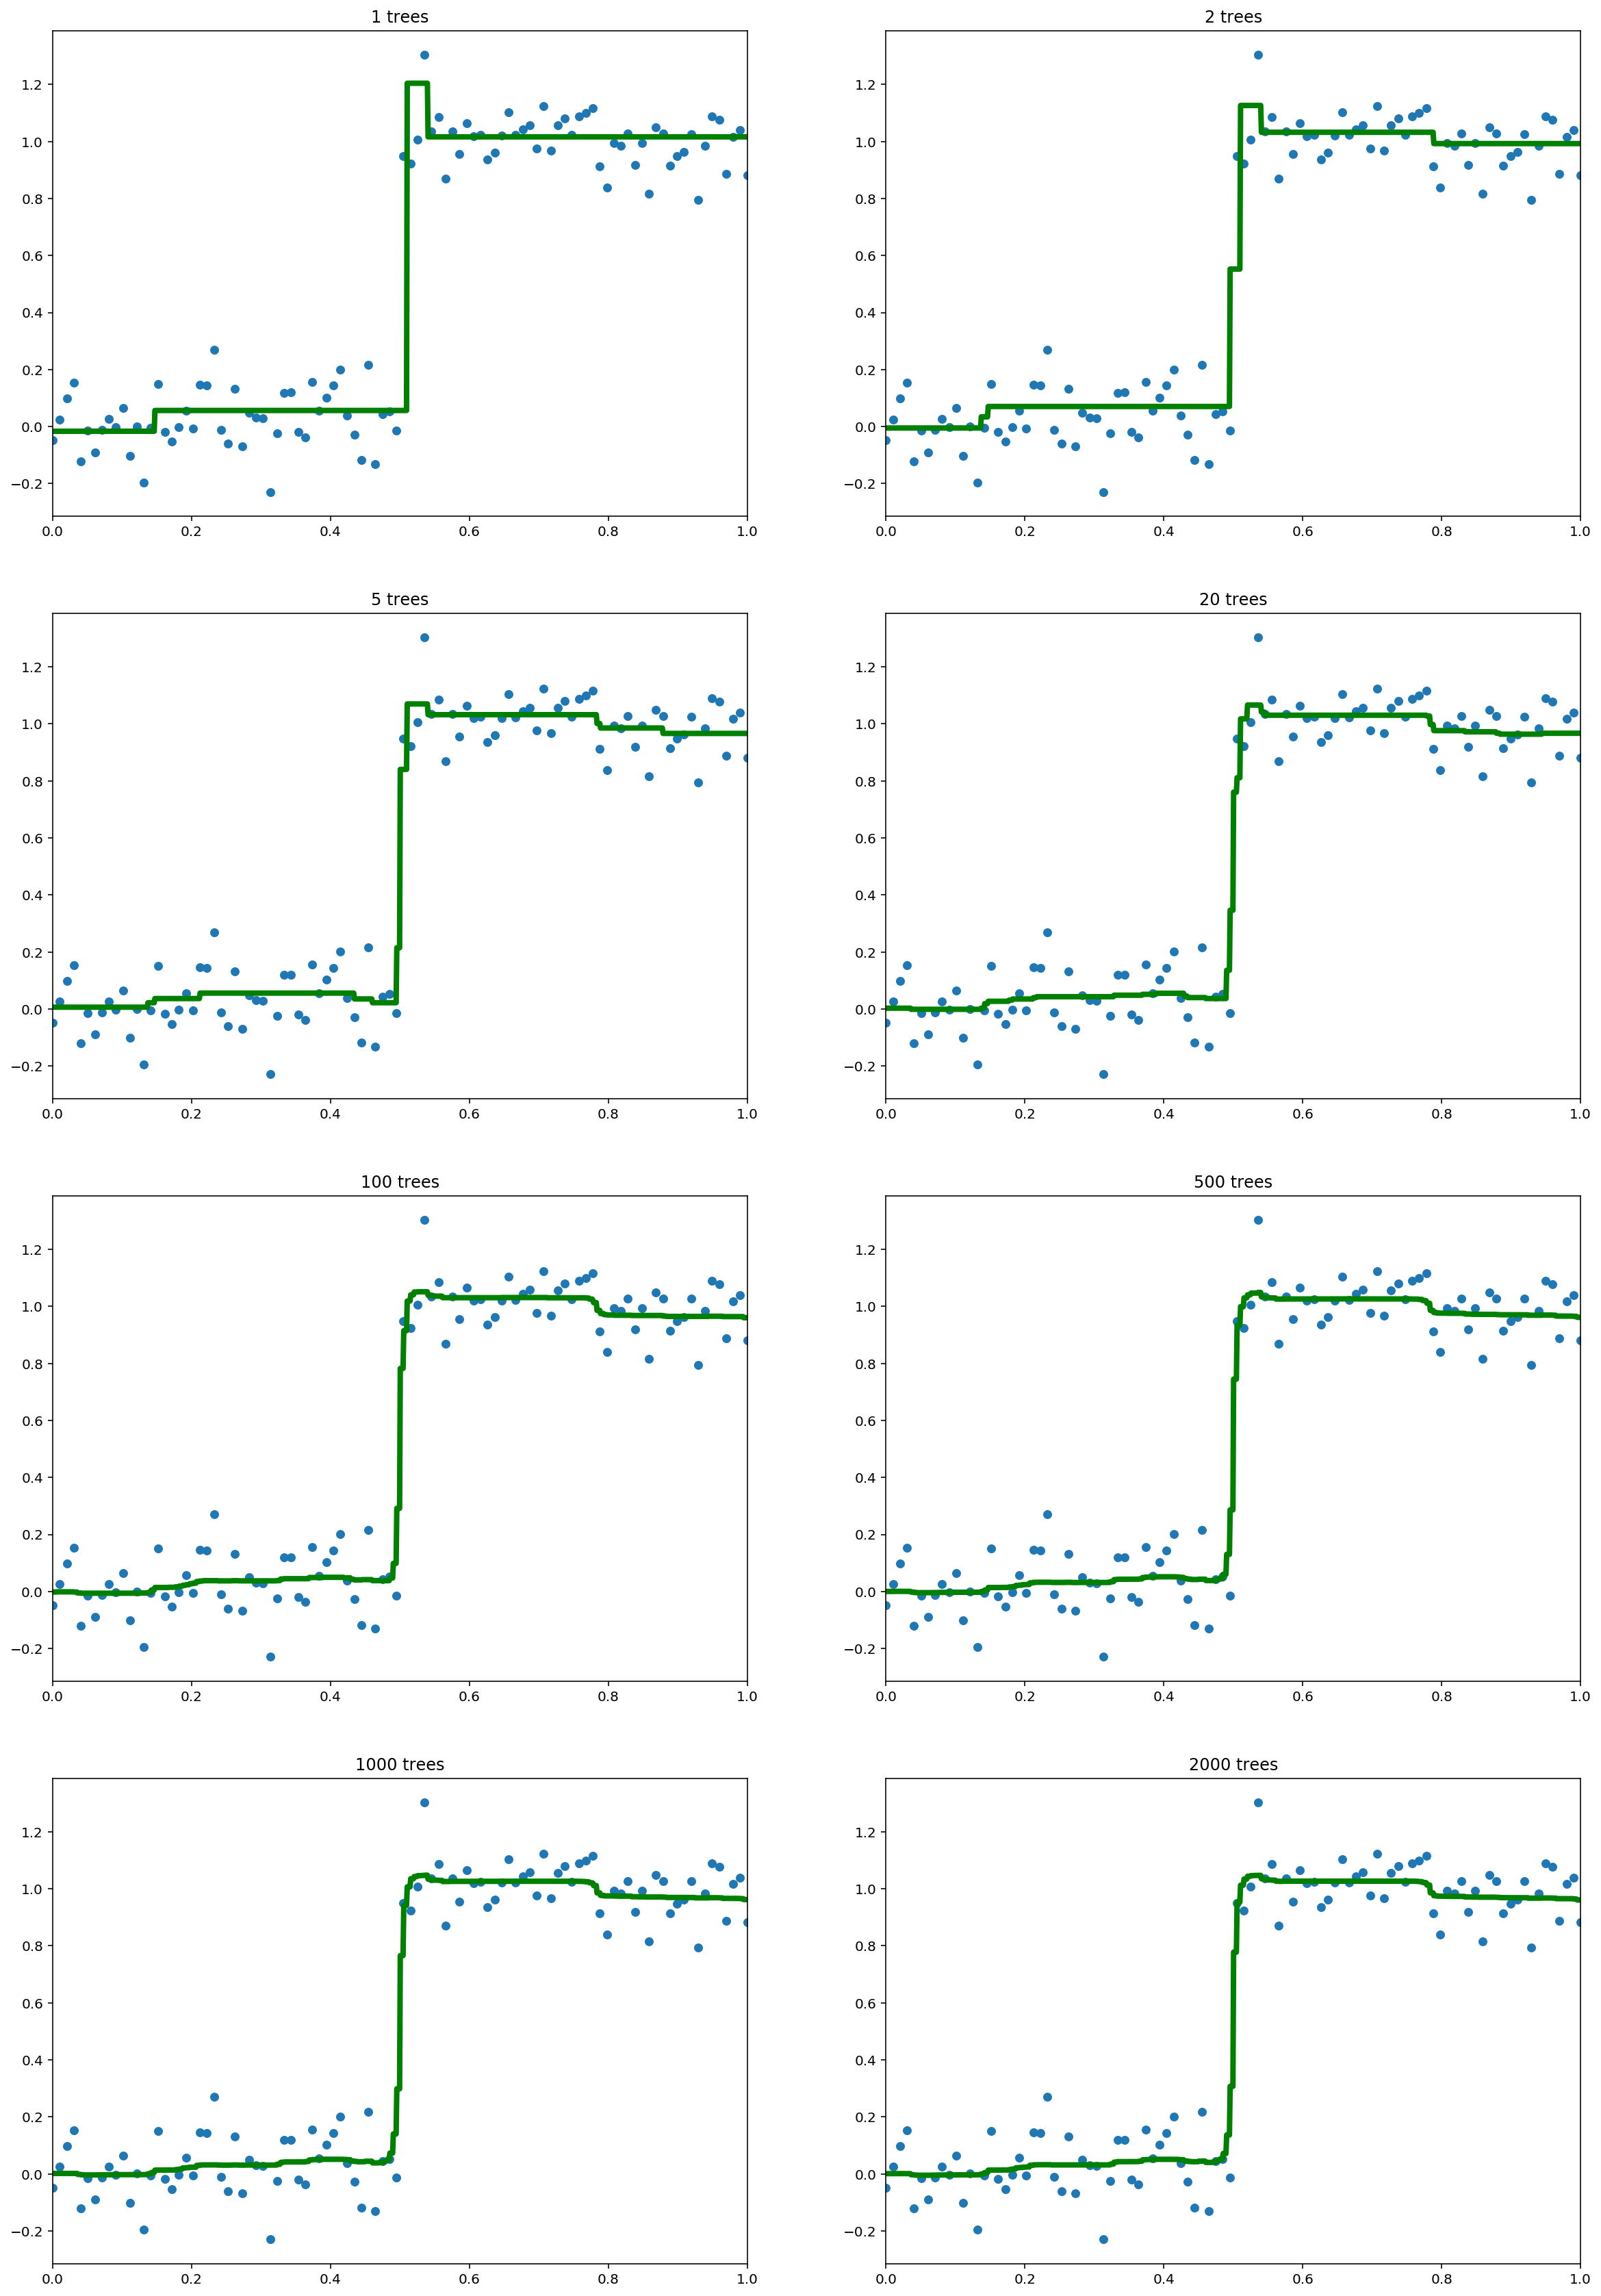

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

reg = BaggingRegressor(DecisionTreeRegressor(max_depth=2), warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Можно заметить, что с некоторого момента итоговая функция перестает меняться с ростом количества деревьев.

Теперь проделаем то же самое для градиентного бустинга.

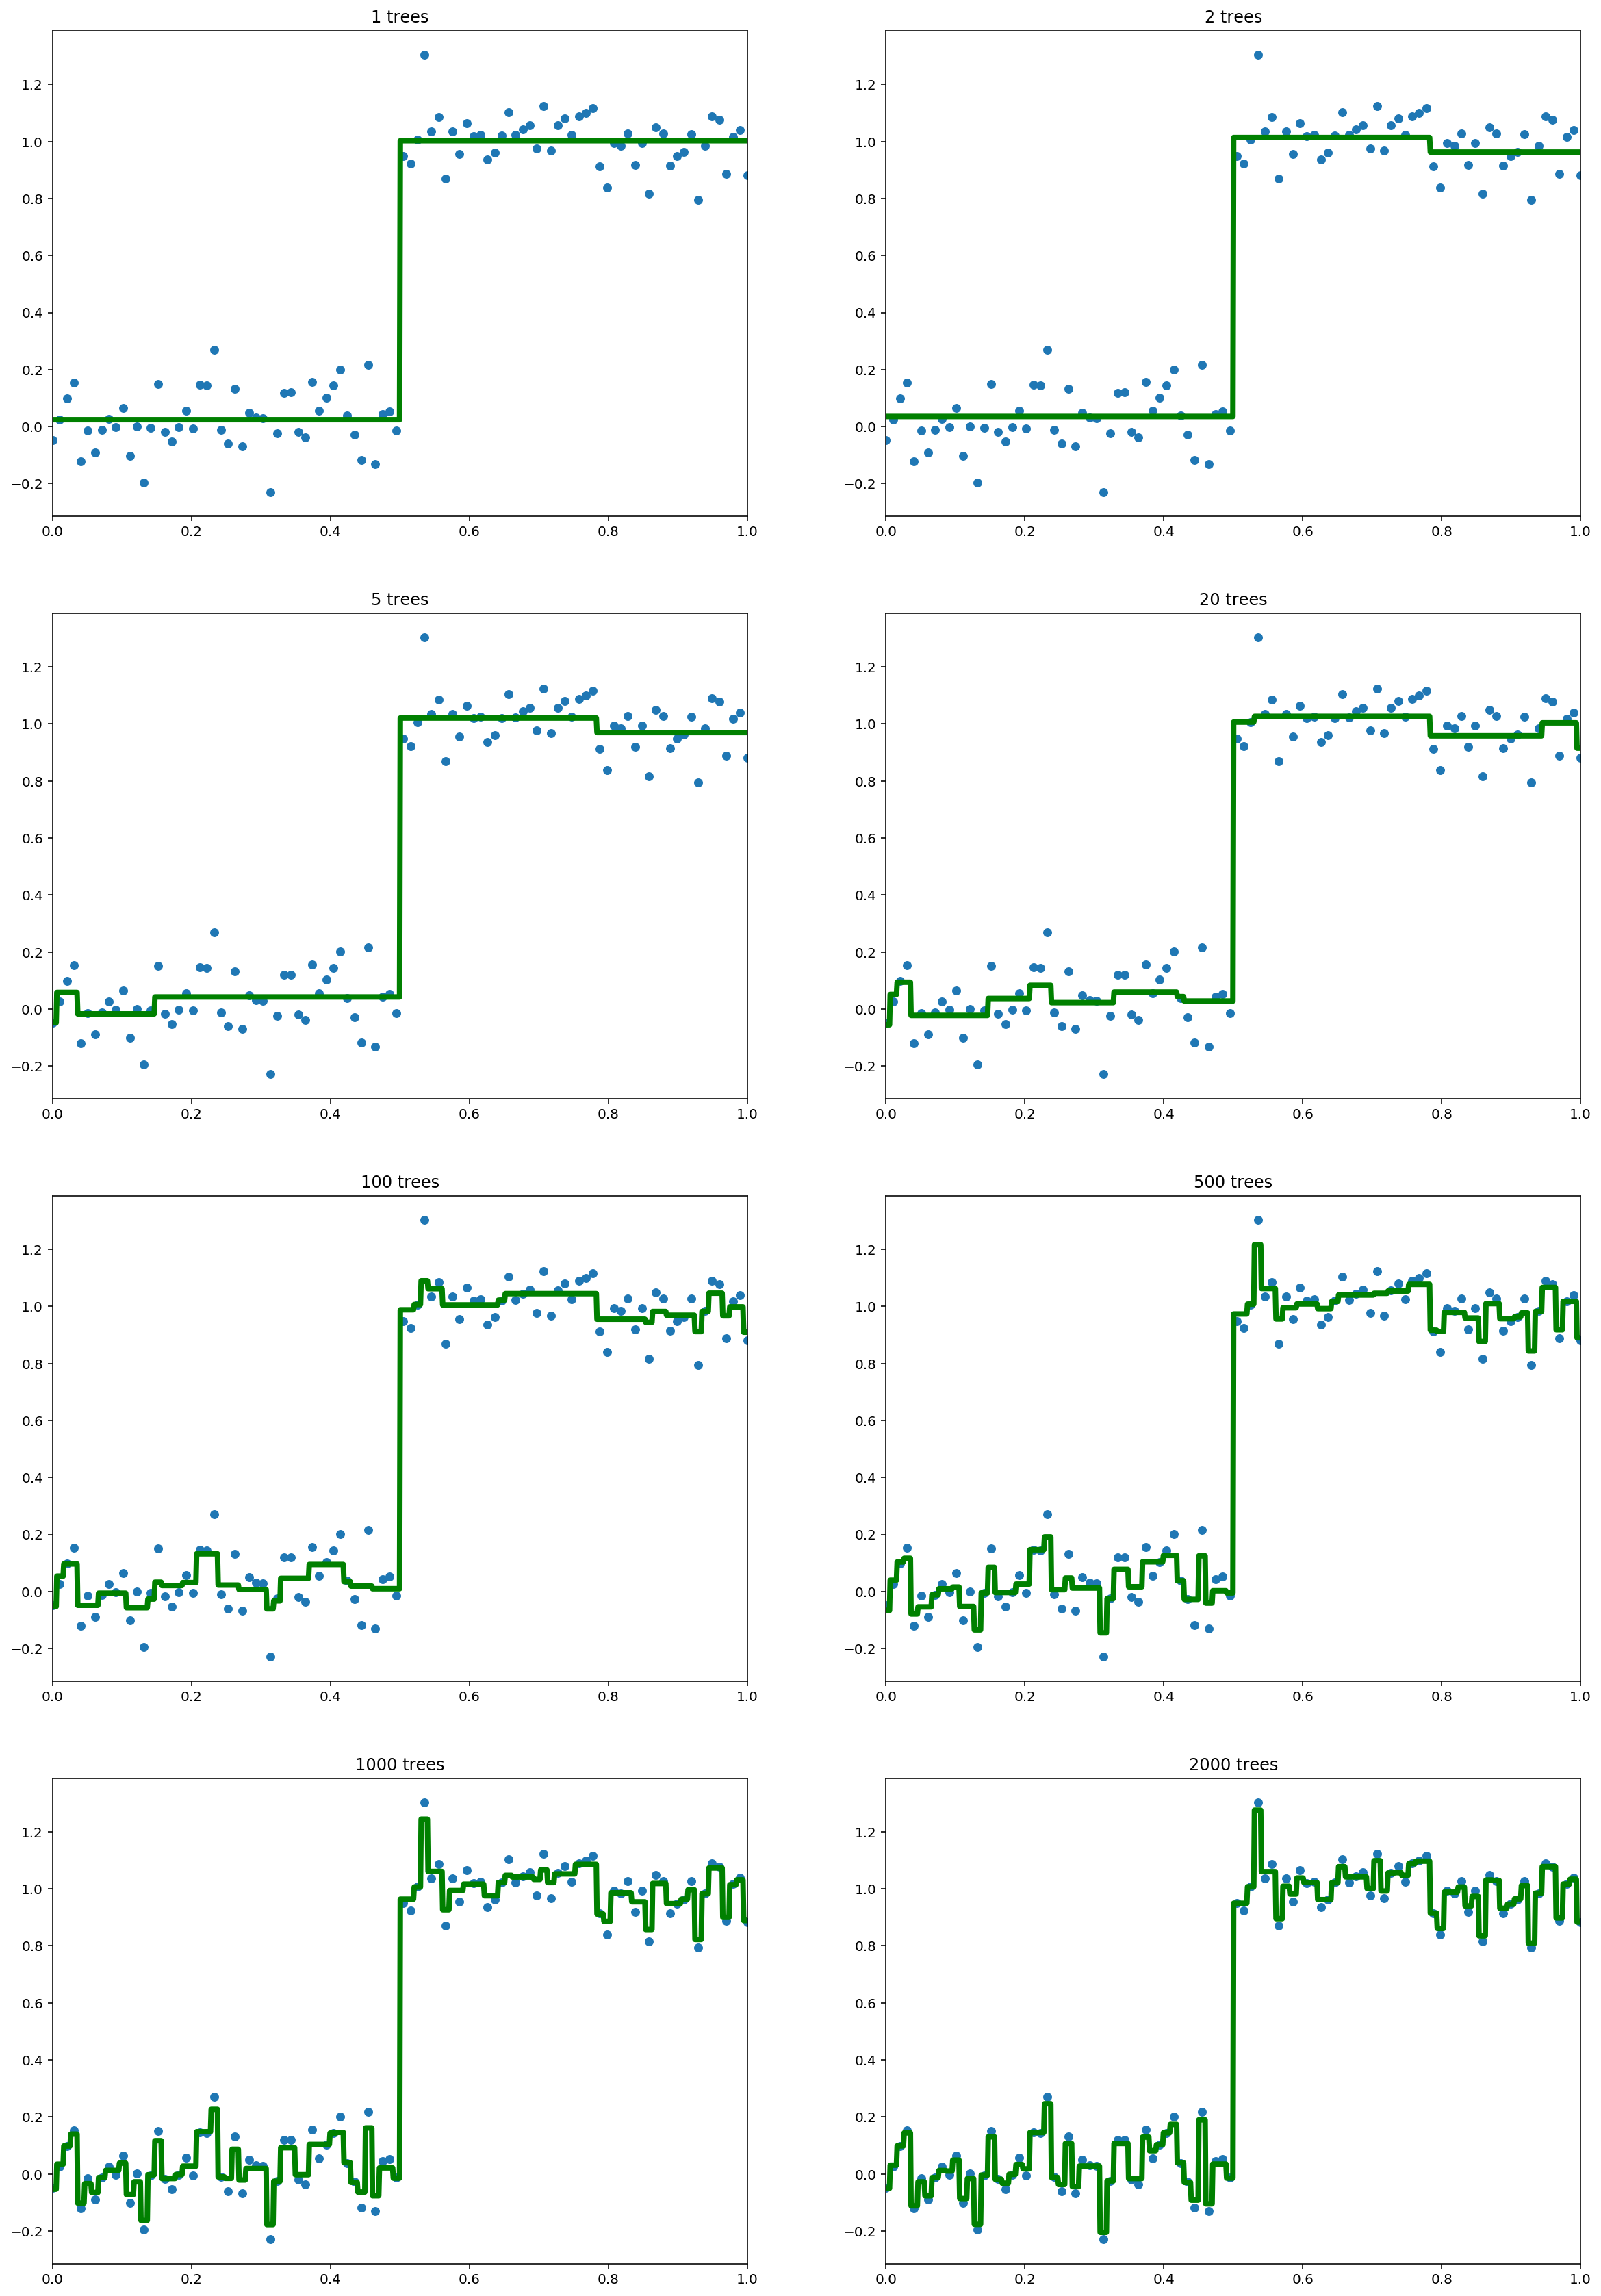

In [4]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Градиентный бустинг довольно быстро построил истинную зависимость, после чего начал настраиваться уже на конкретные объекты обучающей выборки, из-за чего сильно переобучился.


Бороться с этой проблемой можно с помощью выбора очень простого базового алгоритма или
же искусственным снижением веса новых алгоритмов при помощи шага $\eta$:
$$a_N(x) = \sum_{n=1}^N \eta \gamma_n b_n(x).$$

Такая поправка замедляет обучение по сравнению с бэггингом, но зато позволяет получить менее переобученный алгоритм. Тем не менее, важно понимать, что переобучение всё равно будет иметь место при обучении сколь угодно большого количества базовых алгоритмов для фиксированного $\eta$.

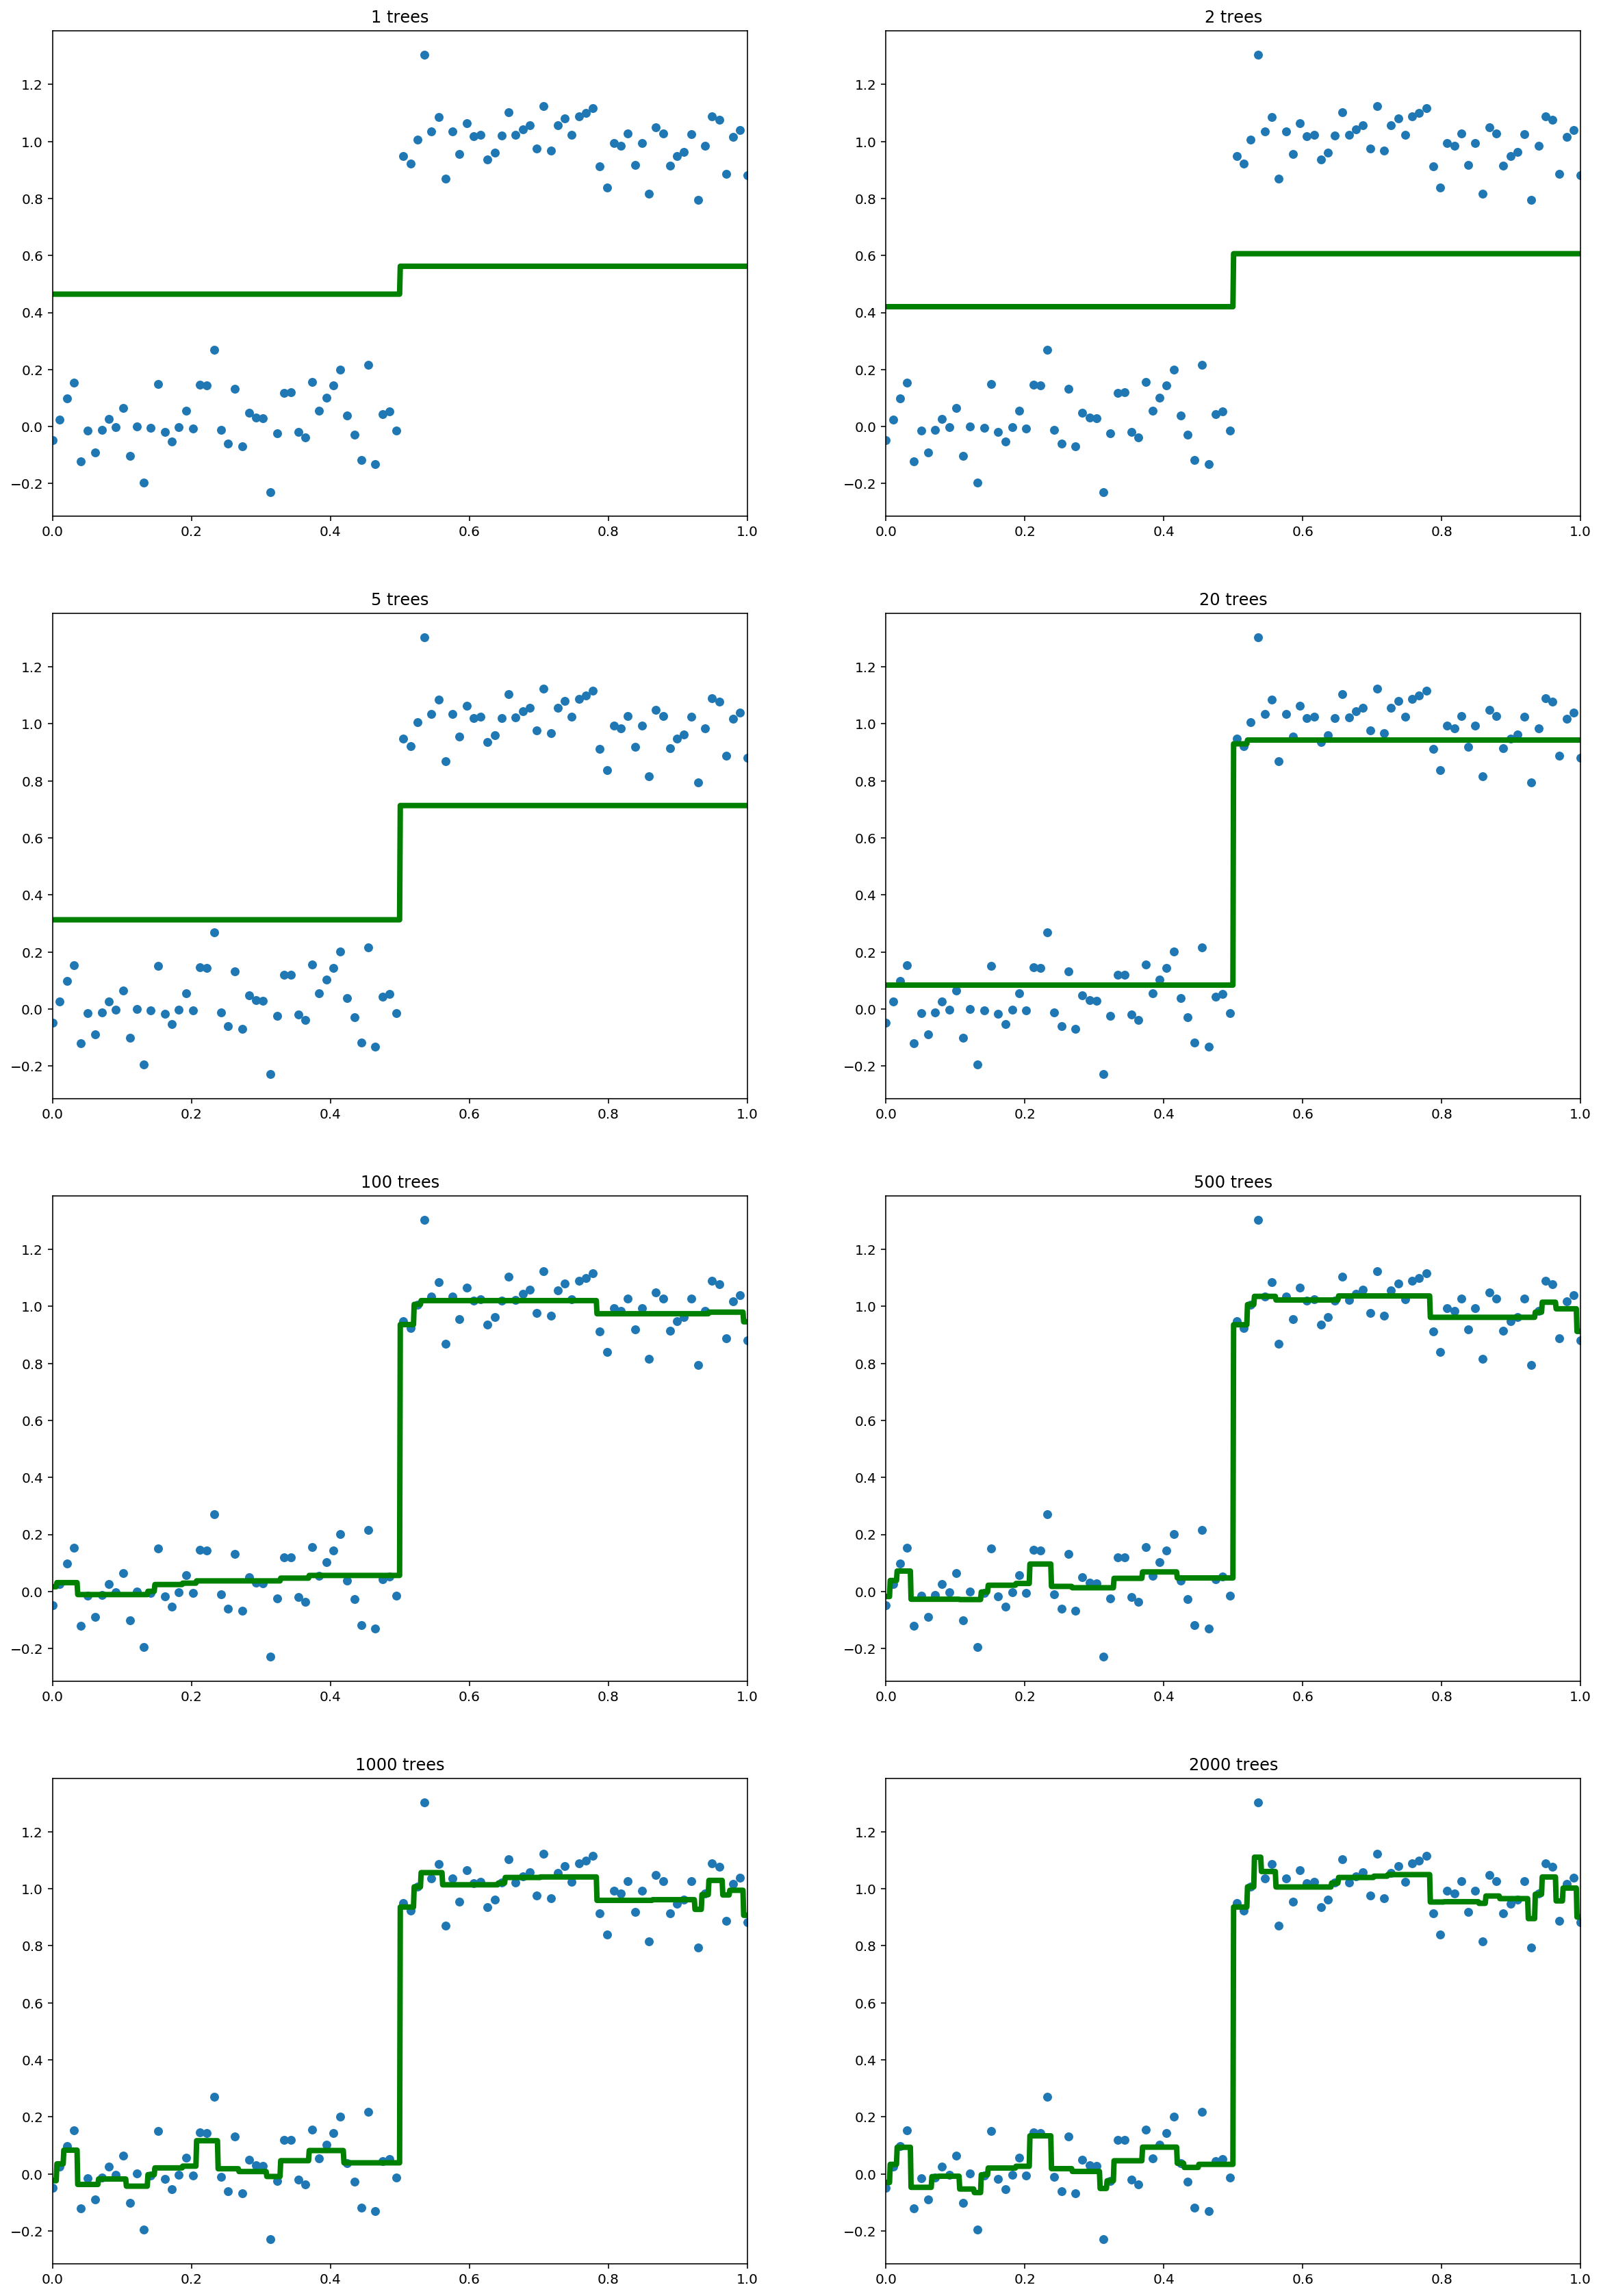

In [5]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Теперь проверим описанный выше эффект на реальных данных.

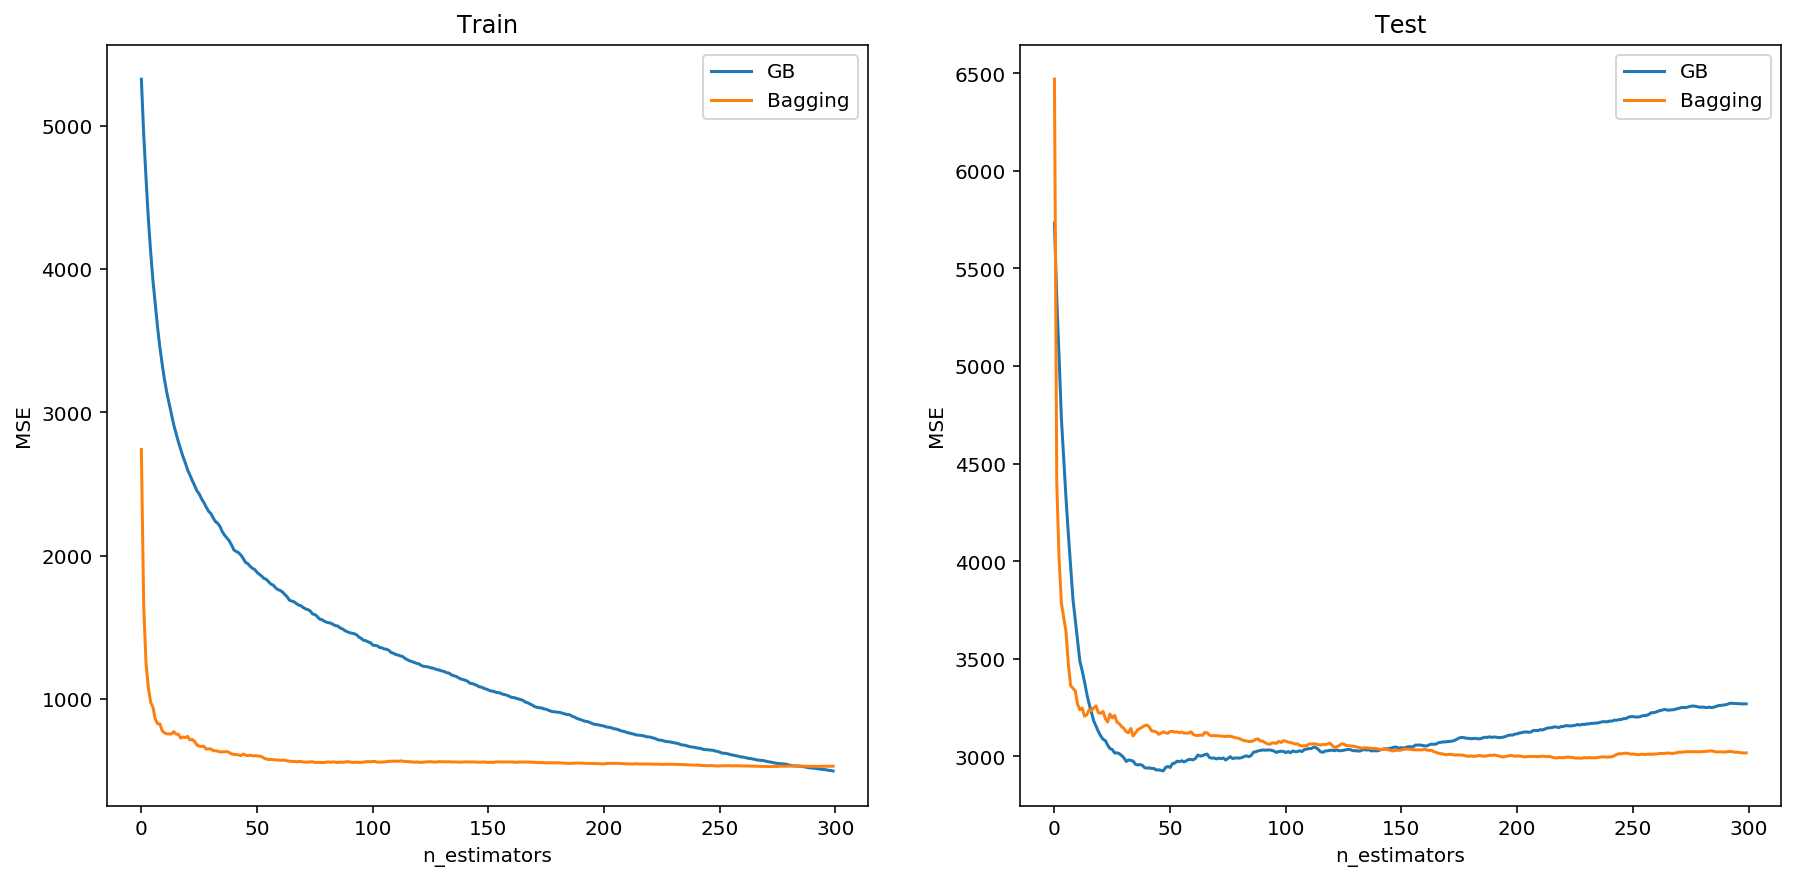

In [6]:
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5)

MAX_ESTIMATORS = 300

gbclf = BaggingRegressor(warm_start=True)
err_train_bag = []
err_test_bag = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_bag.append(mean_squared_error(Y_train, gbclf.predict(X_train)))
    err_test_bag.append(mean_squared_error(Y_test, gbclf.predict(X_test)))
    
gbclf = GradientBoostingRegressor(warm_start=True, max_depth=2, learning_rate=0.1)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_gb.append(mean_squared_error(Y_train, gbclf.predict(X_train)))
    err_test_gb.append(mean_squared_error(Y_test, gbclf.predict(X_test)))
    
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(err_train_gb, label='GB')
plt.plot(err_train_bag, label='Bagging')
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.legend()
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(err_test_gb, label='GB')
plt.plot(err_test_bag, label='Bagging')
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.legend()
plt.title('Test')
plt.gcf().set_size_inches(15,7)

## Градиентный бустинг и случайные леса

Сравним поведение двух методов построения композиции алгоритмов над деревьями на примере задачи [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse).

In [7]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

data = pd.read_csv('train_bio.csv')
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

In [8]:
%%time
gbm = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, verbose=True).fit(X_train, y_train) 
# verbose показывает loss на обучающей выборке и оставшееся время

      Iter       Train Loss   Remaining Time 
         1           1.2613           16.31s
         2           1.1715           14.92s
         3           1.1009           14.01s
         4           1.0529           13.11s
         5           1.0130           13.06s
         6           0.9740           12.53s
         7           0.9475           12.10s
         8           0.9197           11.64s
         9           0.8979           11.45s
        10           0.8730           11.32s
        20           0.7207           10.44s
        30           0.6055            9.78s
        40           0.5244            9.20s
        50           0.4501            8.66s
        60           0.3908            8.16s
        70           0.3372            7.67s
        80           0.3009            7.19s
        90           0.2603            6.74s
       100           0.2327            6.29s
       200           0.0835            2.06s
CPU times: user 10.3 s, sys: 32 ms, total: 10.3 s
Wall

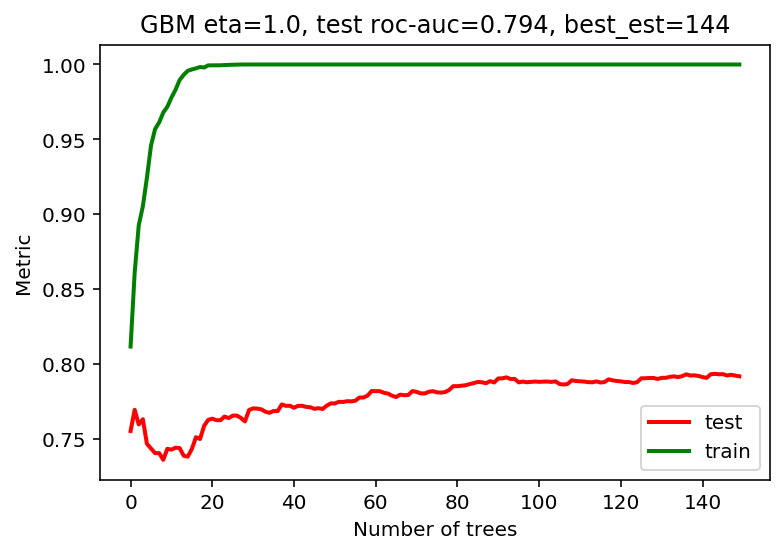

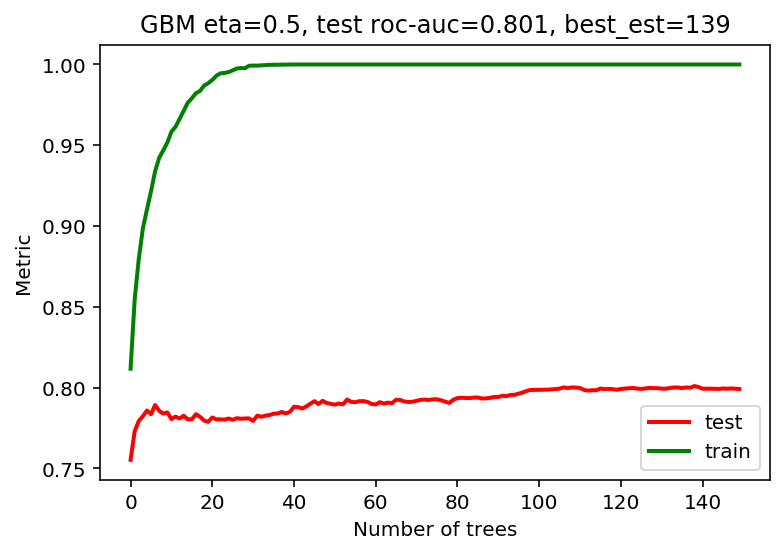

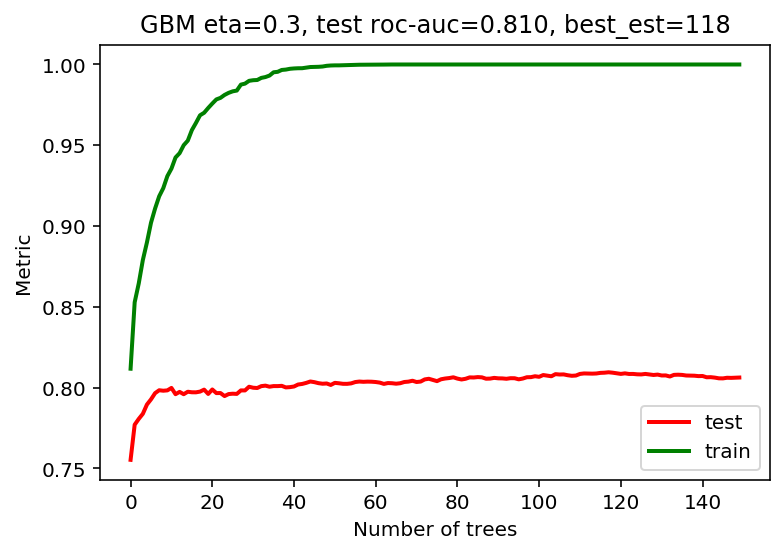

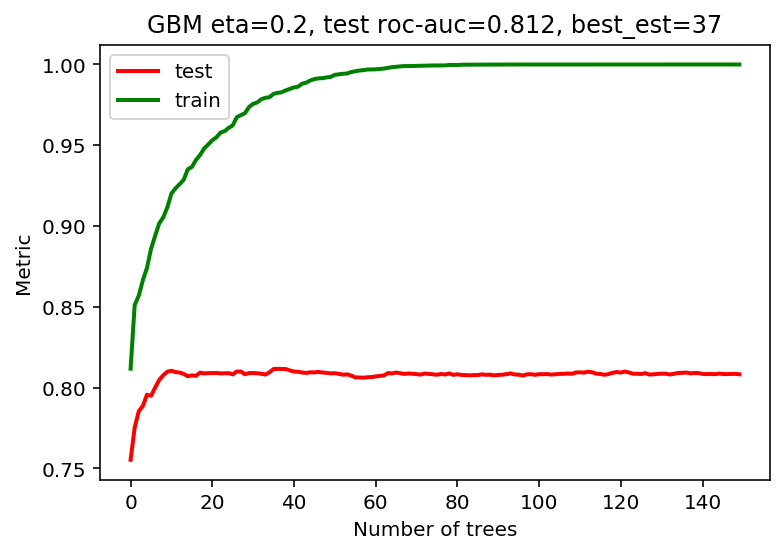

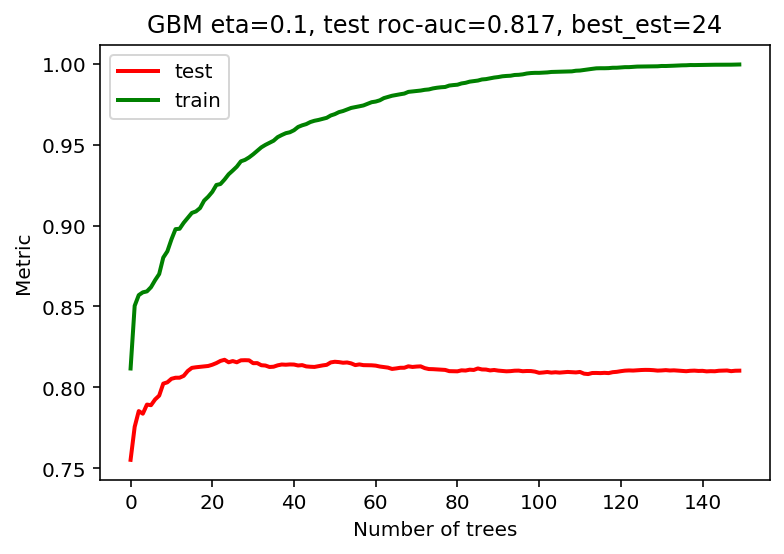

In [11]:
import numpy as np
from sklearn.metrics import roc_auc_score

for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:

    gbm = GradientBoostingClassifier(n_estimators=150, learning_rate=learning_rate, random_state=241).fit(X_train, y_train)
    
    l = roc_auc_score

    test_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_test)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        test_deviance[i] = roc_auc_score(y_test, y_pred)
    
    train_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_train)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        train_deviance[i] = roc_auc_score(y_train, y_pred)

    plt.figure()
    plt.plot(test_deviance, 'r', linewidth=2)
    plt.plot(train_deviance, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    
    plt.title('GBM eta=%.1f, test roc-auc=%.3f, best_est=%d' % (learning_rate, test_deviance.max(), test_deviance.argmax()+1))
    plt.xlabel('Number of trees')
    plt.ylabel('Metric')

Итого, лучшая композиция построена при $\eta = 0.1$, включает 24 базовых алгоритма и достигает значения 0.817 на контрольной выборке. При этом случайный лес с таким же количеством базовых алгоритмов уступает градиентному бустингу:

In [17]:
rf = RandomForestClassifier(n_estimators=24, random_state=0).fit(X_train, y_train)
print ('Train RF ROC-AUC =', roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
print ('Test RF ROC-AUC = ', roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Train RF ROC-AUC = 0.9999786482947104
Test RF ROC-AUC =  0.8037501166053144


Заметим также, что при всём этом случайный лес, в отличие от градиентного бустинга, использует глубокие деревья, требующие вычислительных мощностей для их обучения.

Для достижения такого же качества случайному лесу требуется гораздо большее число базовых алгоритмов:

In [18]:
for n_estimators in range(10, 101, 10):
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=4).fit(X_train, y_train)
    print (n_estimators, 'trees: train ROC-AUC =',  roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]), 'test ROC-AUC =',  roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

10 trees: train ROC-AUC = 0.9992633661675112 test ROC-AUC = 0.7633732841079515
20 trees: train ROC-AUC = 0.9999537379718727 test ROC-AUC = 0.7969993416284561
30 trees: train ROC-AUC = 0.9999928827649035 test ROC-AUC = 0.8104580615532545
40 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8131781047510386
50 trees: train ROC-AUC = 0.9999999999999999 test ROC-AUC = 0.8189830312358728
60 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8191104001176815
70 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8208984977647659
80 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.820164108525463
90 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.822630535164575
100 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.822070829655781


Напоследок можно посмотреть [визуализацию](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) градиентного бустинга для решающих деревьев различной глубины для функций различного вида.

## Разделяющие поверхности

In [19]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap,
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

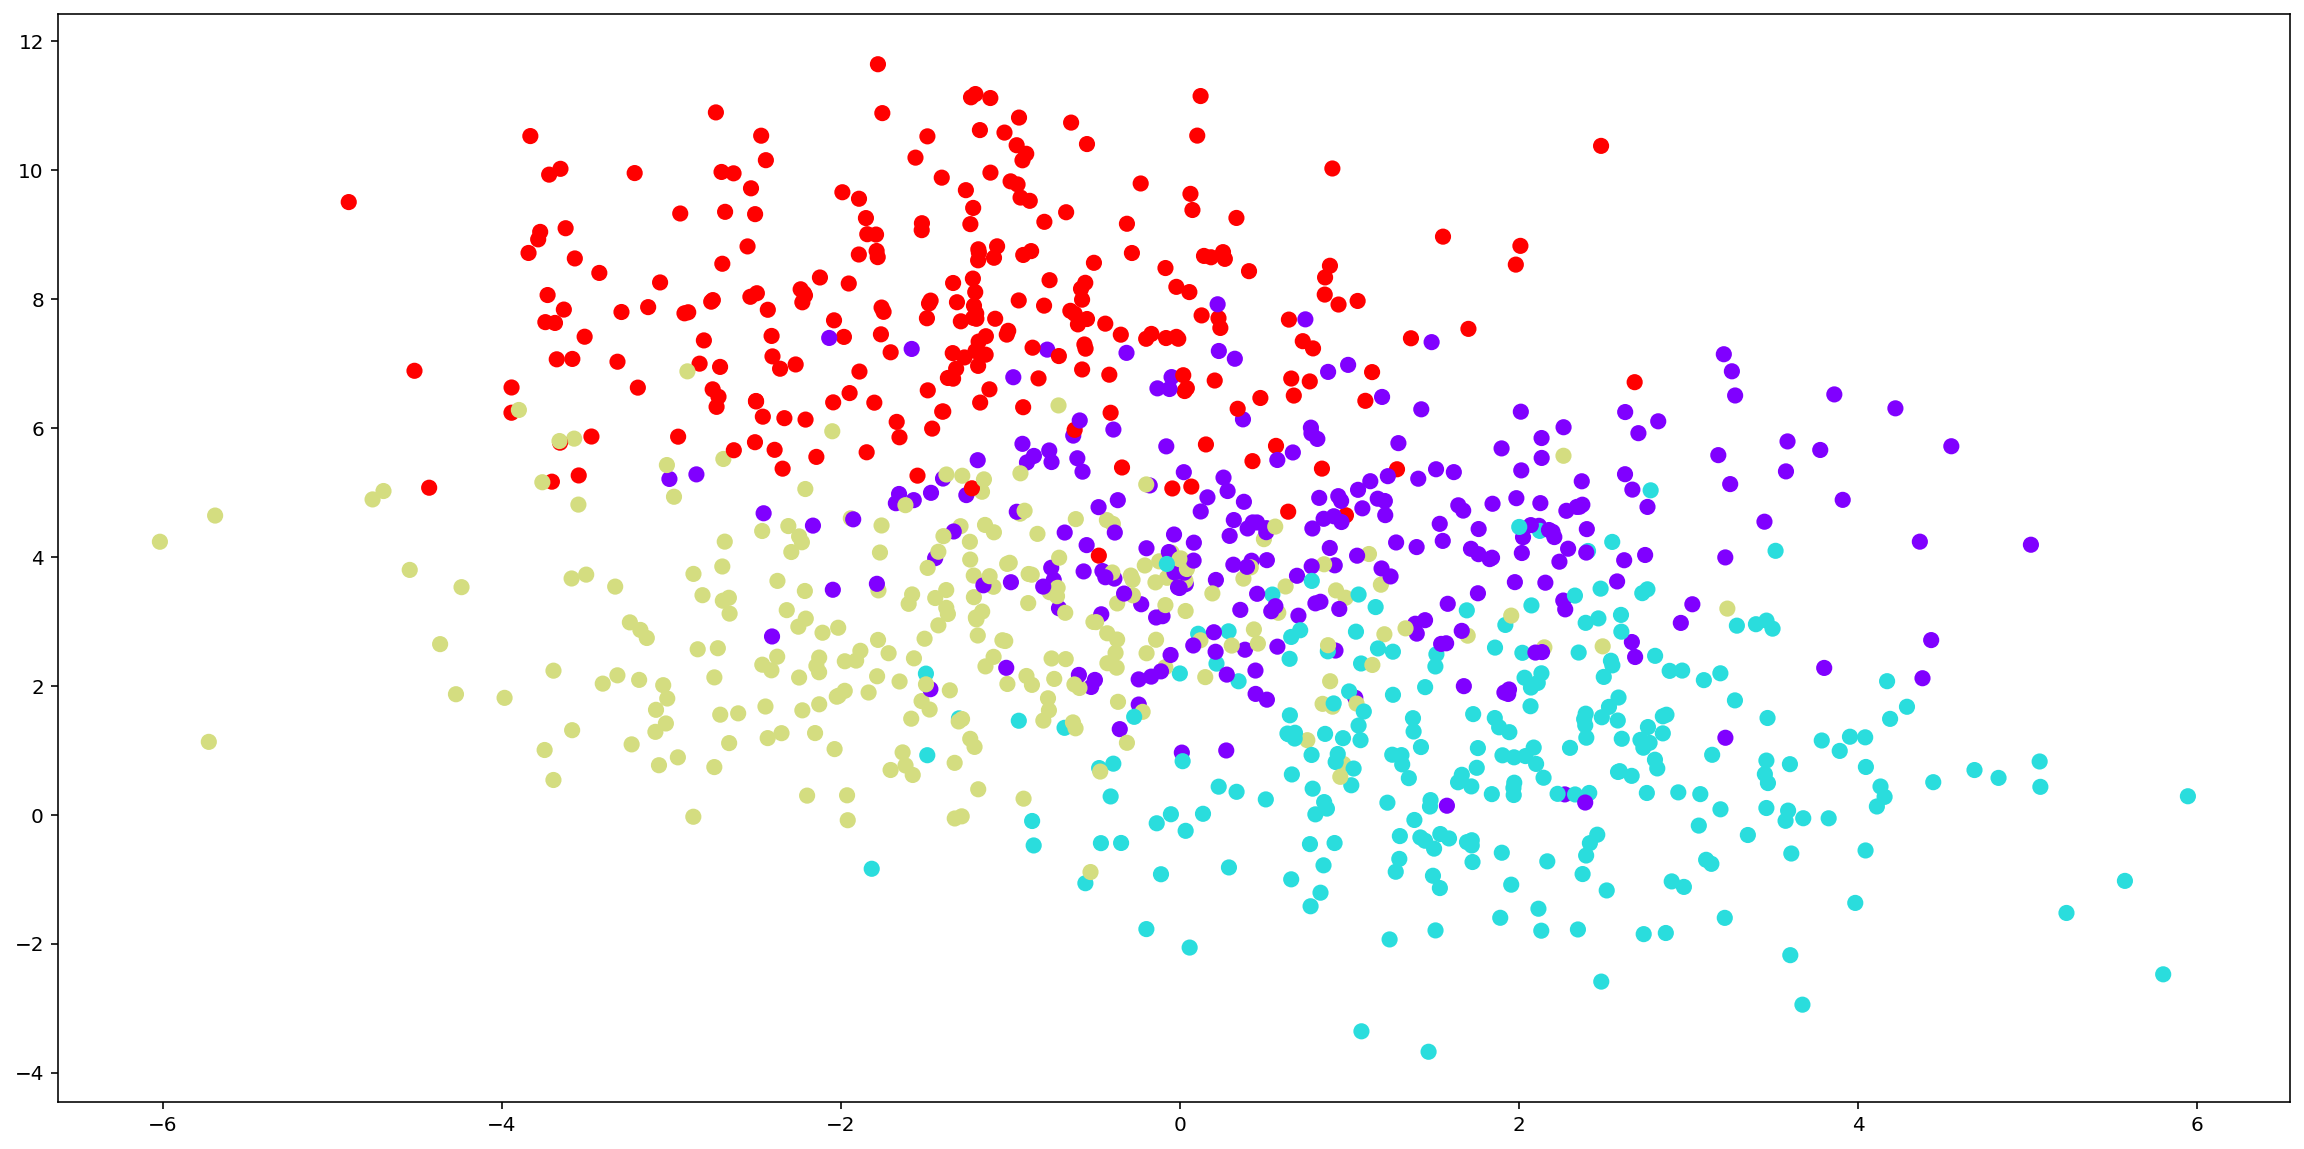

In [20]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, centers=4,
                  random_state=0, cluster_std=1.5)
plt.figure(figsize=(20,10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

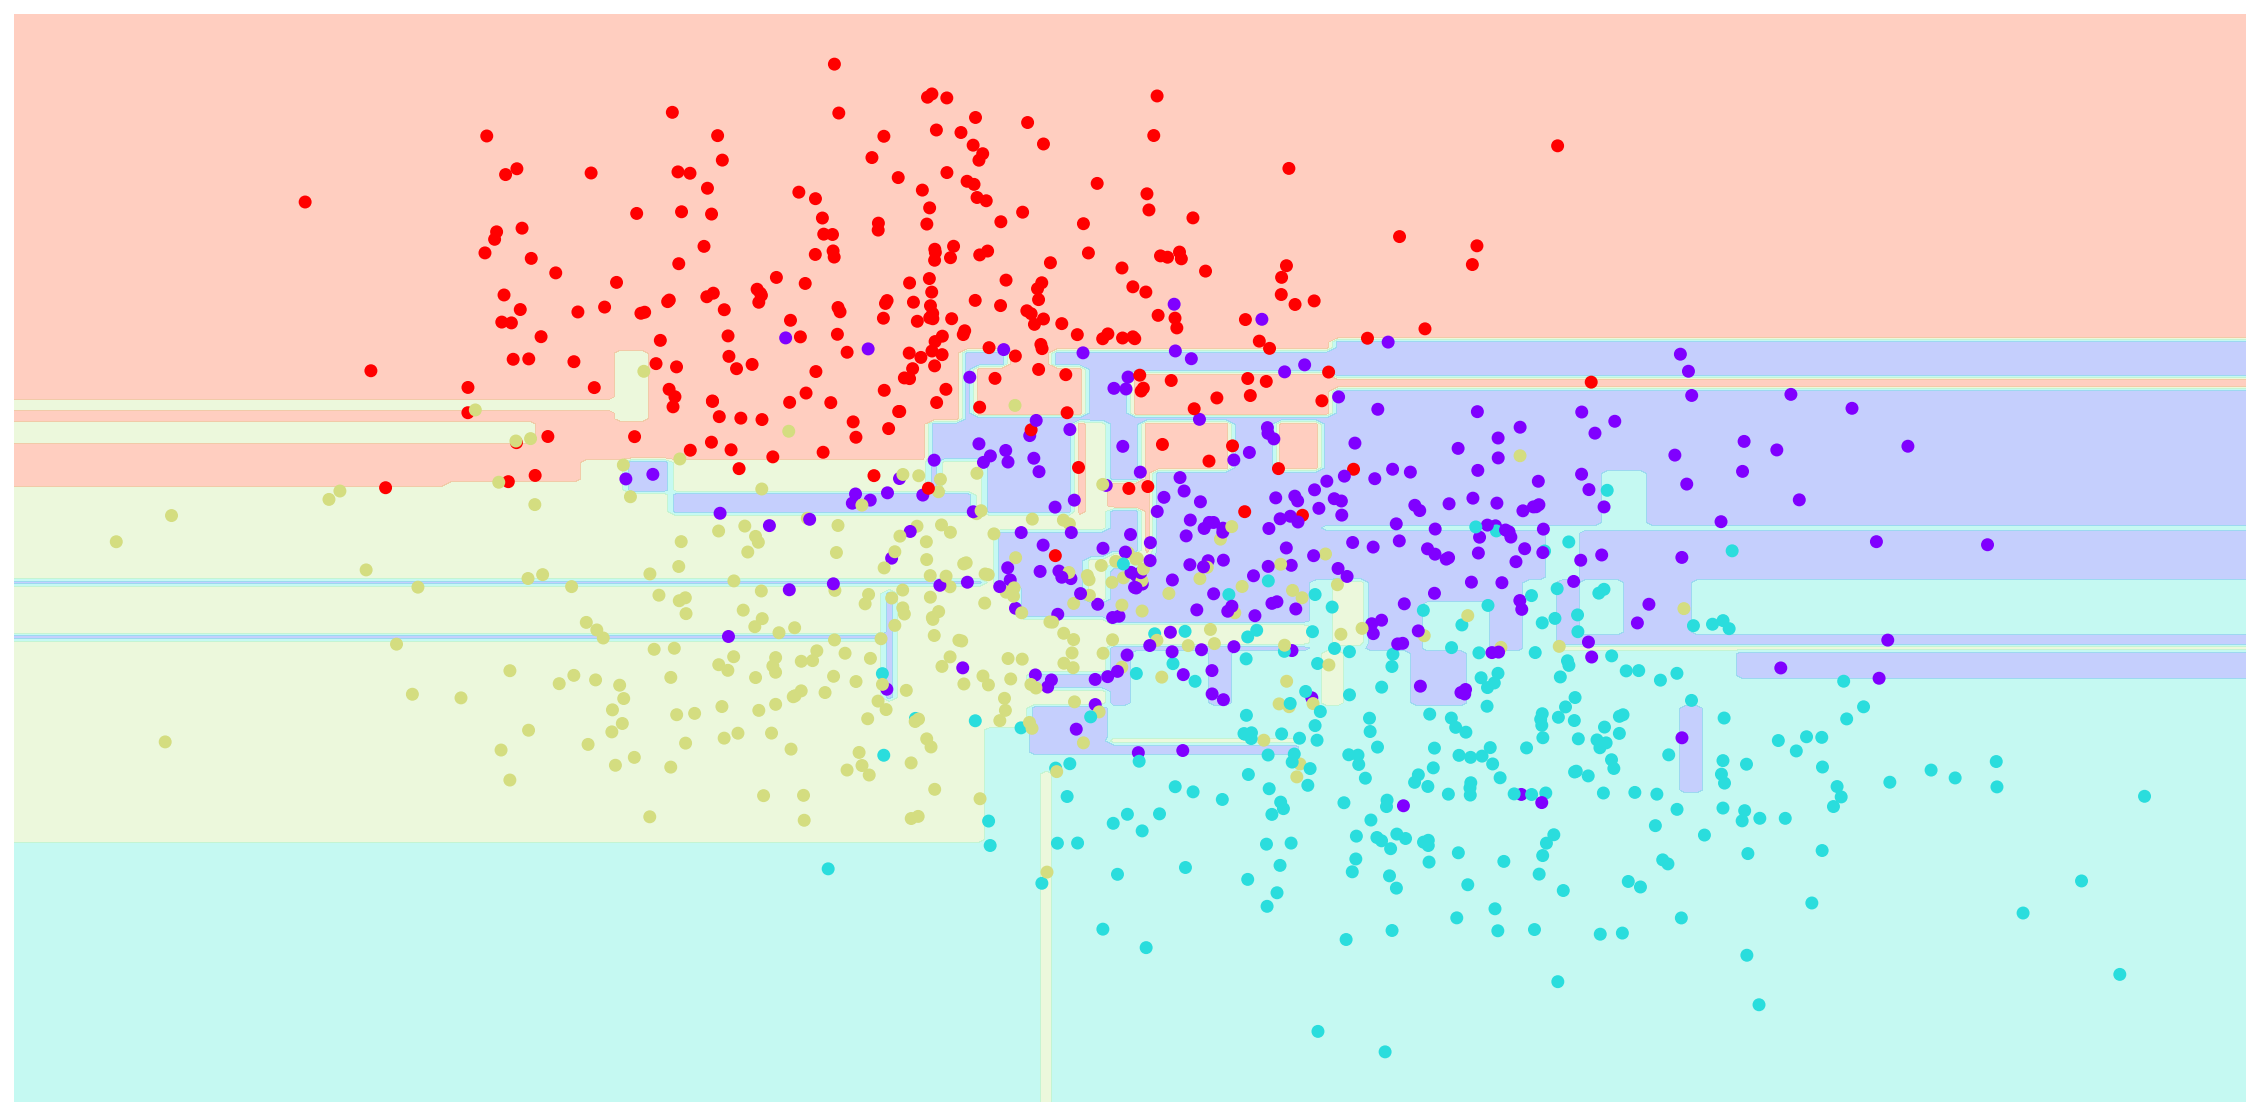

In [21]:
from sklearn.tree import DecisionTreeClassifier
clf_r = DecisionTreeClassifier(max_depth=10)
plt.figure(figsize=(20,10))
visualize_classifier(clf_r, X, y, ax=None, cmap='rainbow')

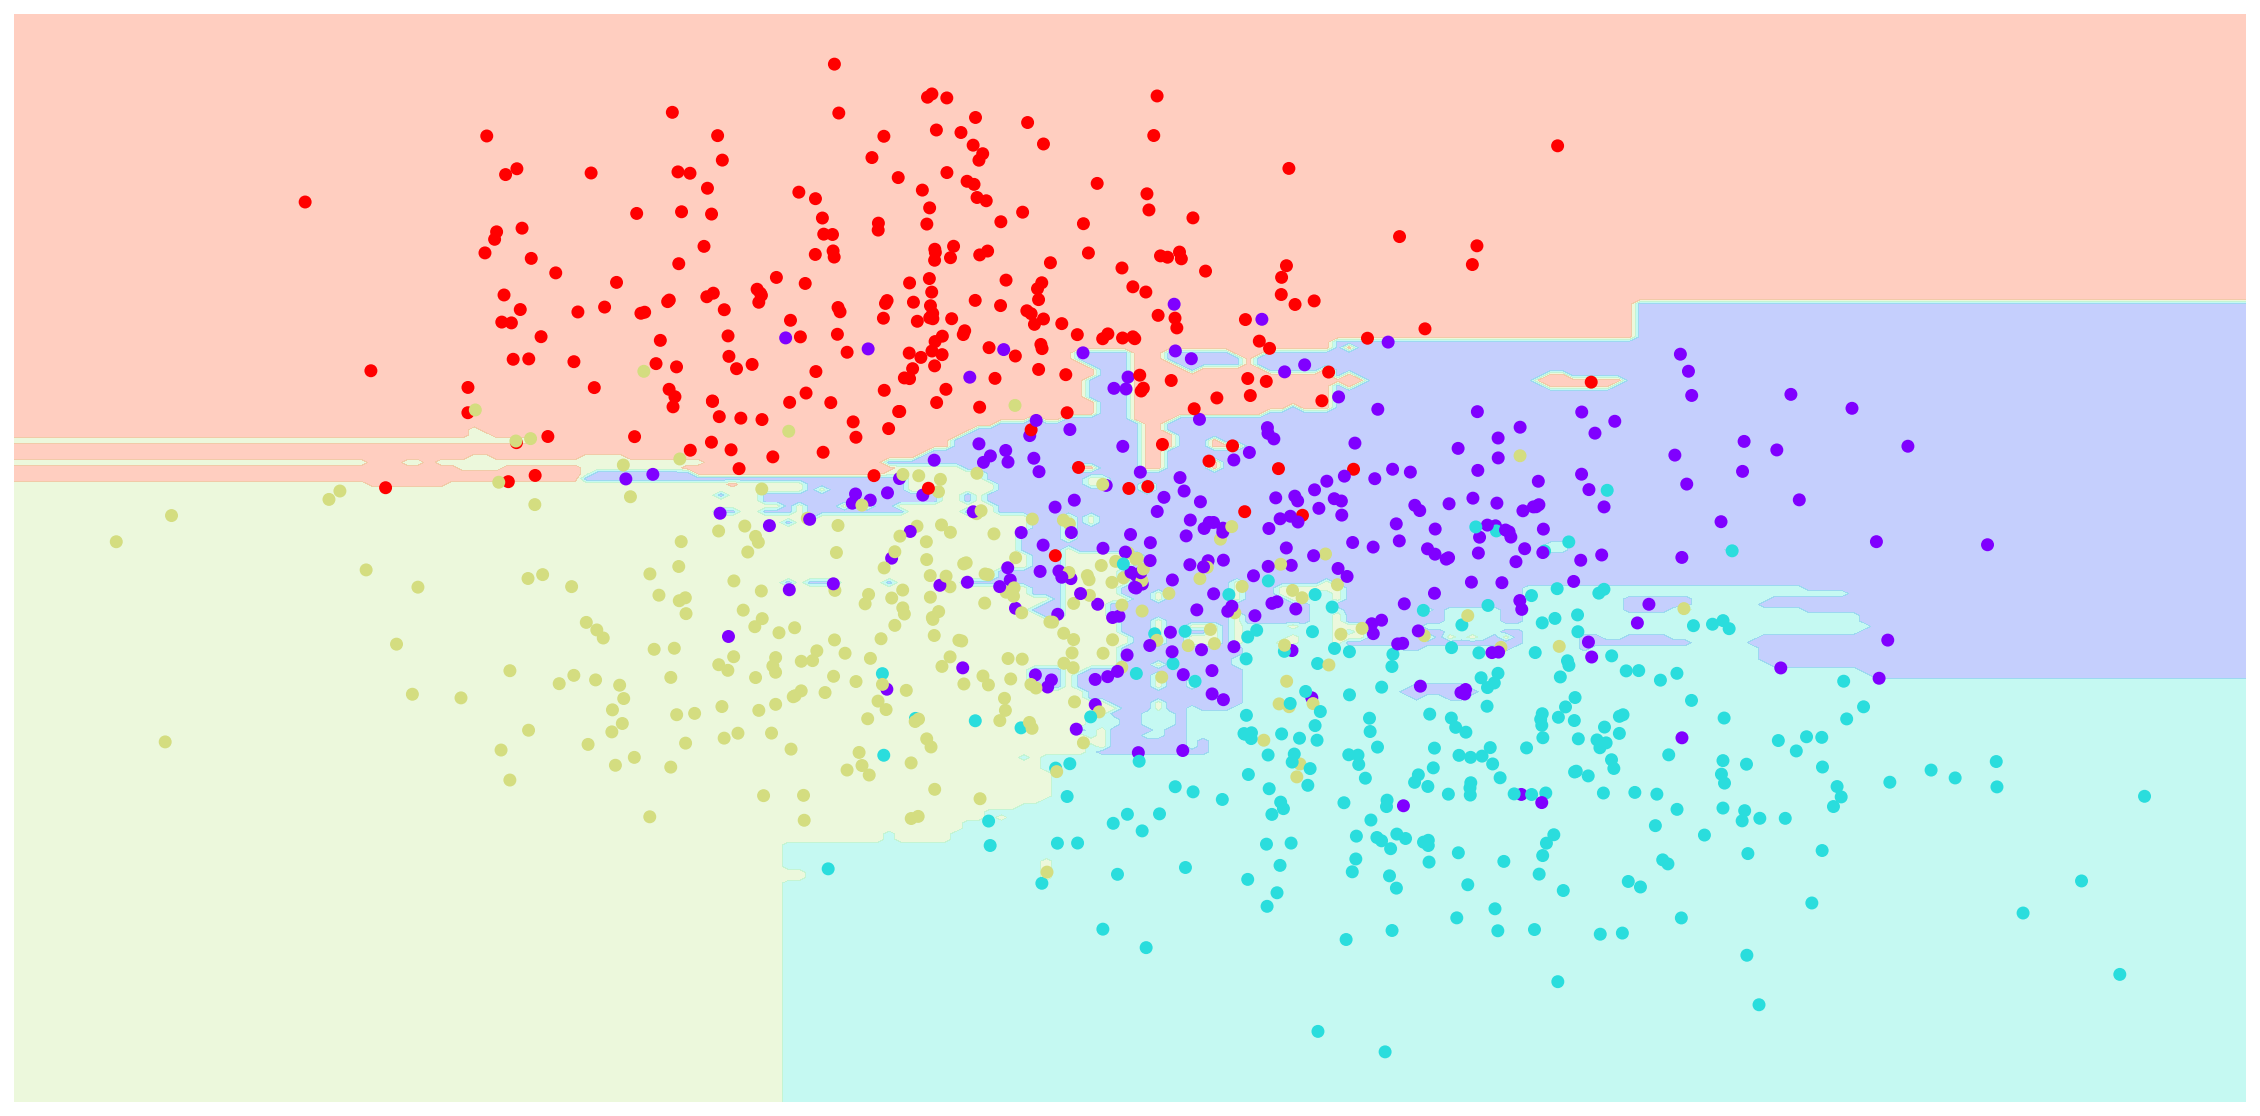

In [22]:
from sklearn.ensemble import RandomForestClassifier
clf_r = RandomForestClassifier(n_estimators=1000, max_depth=10)
plt.figure(figsize=(20,10))
visualize_classifier(clf_r, X, y, ax=None, cmap='rainbow')

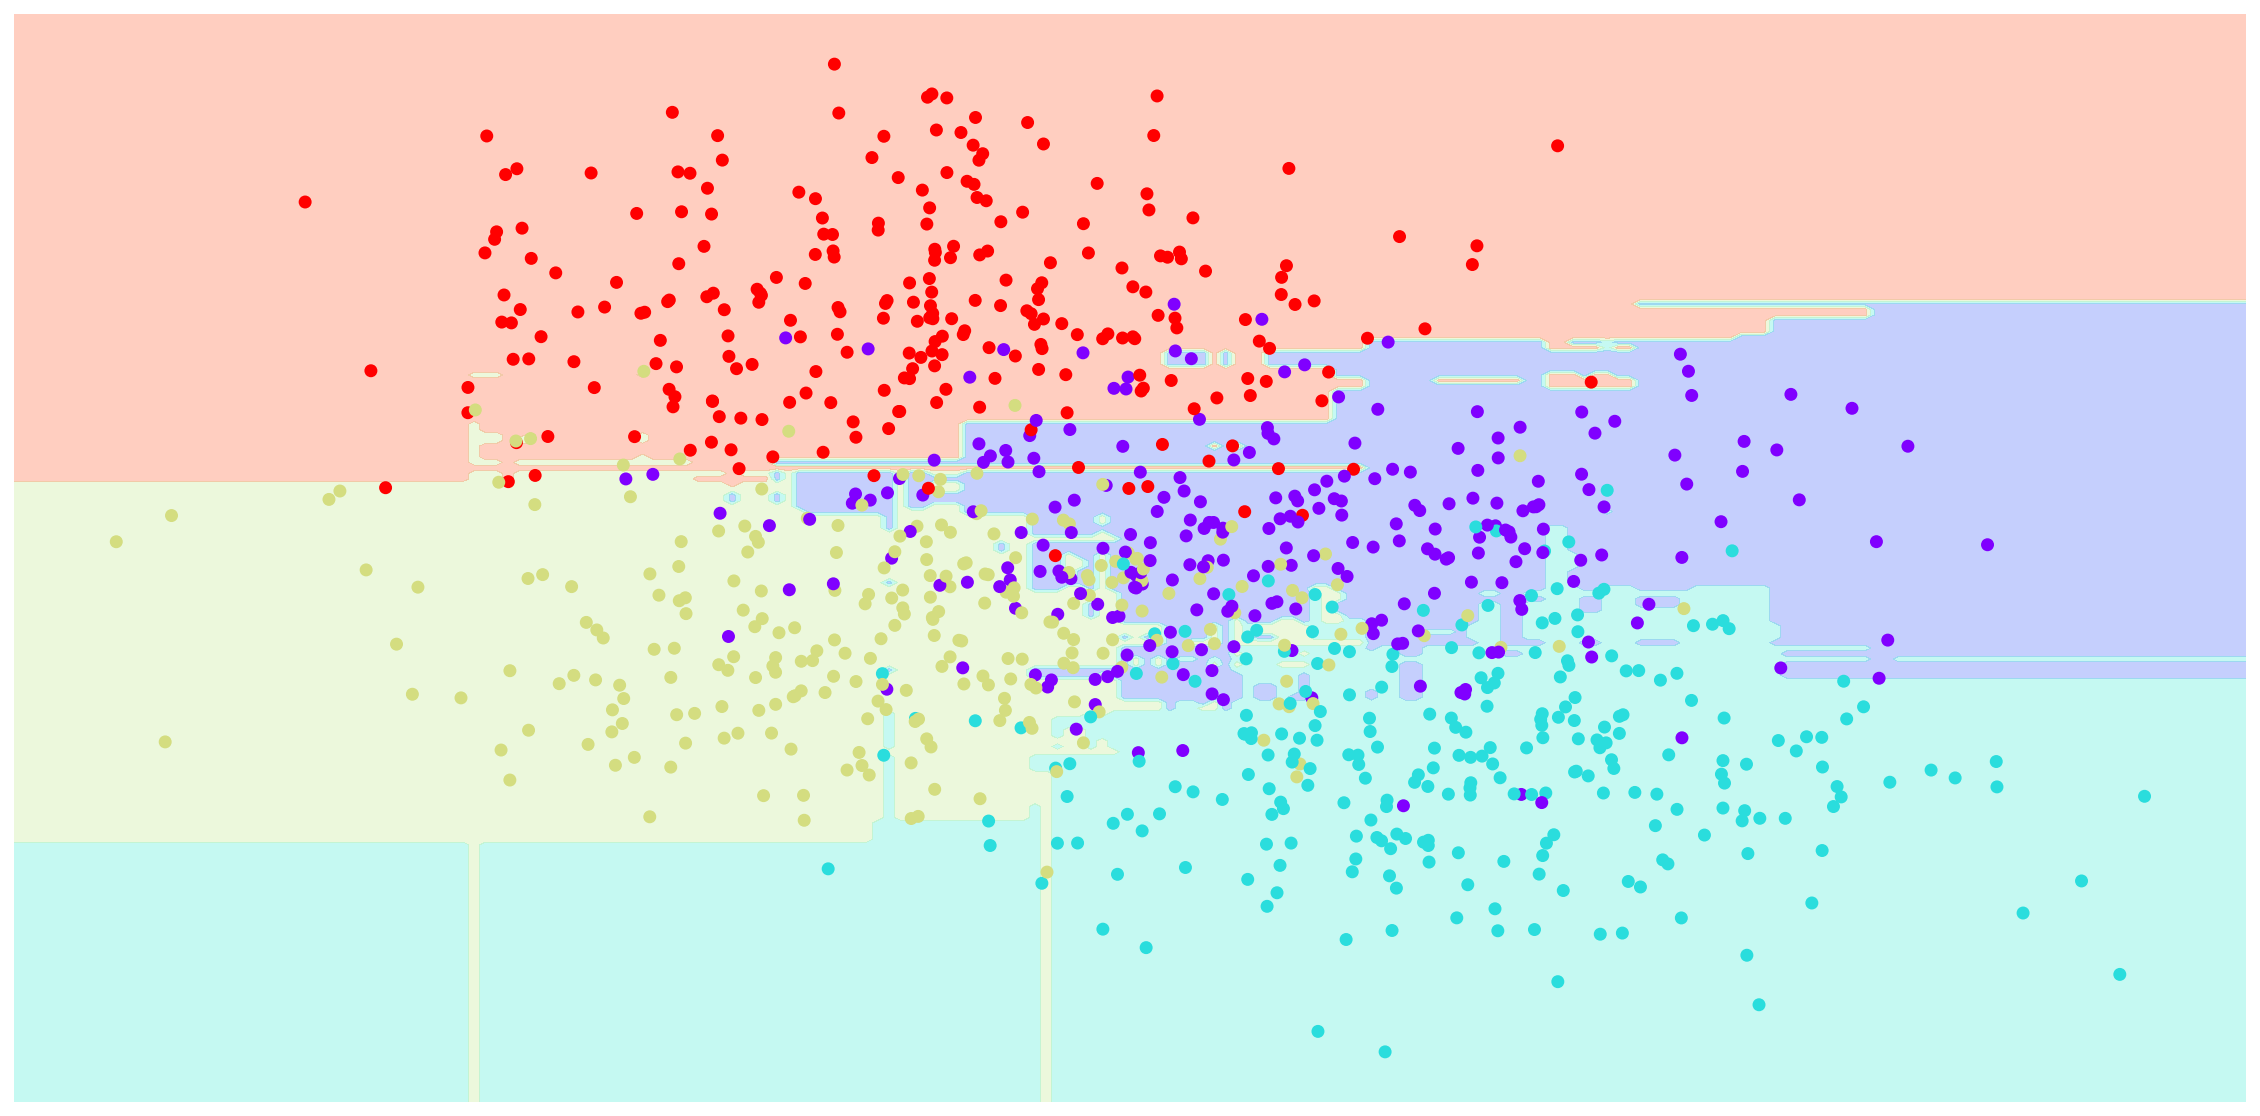

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
clf_r = GradientBoostingClassifier(n_estimators=1000, learning_rate=1e-2, max_depth=3)
plt.figure(figsize=(20,10))
visualize_classifier(clf_r, X, y, ax=None, cmap='rainbow')